In [1]:
#Add libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [2]:
#Load data processed on the HPC

prs = pd.read_csv("../data/protein_prs_cases.csv", sep="\t", index_col=0)

prs.head()

,Group,Case,Sex,APOB.2797.56.2,APOE.2937.10.2,CRP.4337.49.2
0,A,2,2,-0.318171,-0.133883,-0.266216
1,A,2,2,0.689710,0.421410,-1.659654
2,A,2,1,-2.252077,-1.003851,-0.420168
3,A,2,2,0.689710,-0.133883,-1.053209
4,A,2,2,-0.318171,0.843965,-0.344878


              Case          Sex  APOB.2797.56.2  APOE.2937.10.2  CRP.4337.49.2
count  6244.000000  6244.000000    6.244000e+03    6.244000e+03   6.244000e+03
mean      1.686579     1.598334   -7.206916e-12   -1.933456e-10   2.802562e-10
std       0.463921     0.490274    9.998398e-01    9.998398e-01   9.998398e-01
min       1.000000     1.000000   -4.349135e+00   -6.502712e+00  -3.734828e+00
25%       1.000000     1.000000   -3.181712e-01   -1.338832e-01  -6.136645e-01
50%       2.000000     2.000000   -3.181712e-01    2.886725e-01   1.042077e-01
75%       2.000000     2.000000    6.897097e-01    8.173019e-01   7.533913e-01
max       2.000000     2.000000    1.748612e+00    1.222361e+00   3.271693e+00
Group              object
Case                int64
Sex                 int64
APOB.2797.56.2    float64
APOE.2937.10.2    float64
CRP.4337.49.2     float64
dtype: object


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb77768910>,
      dtype=object)

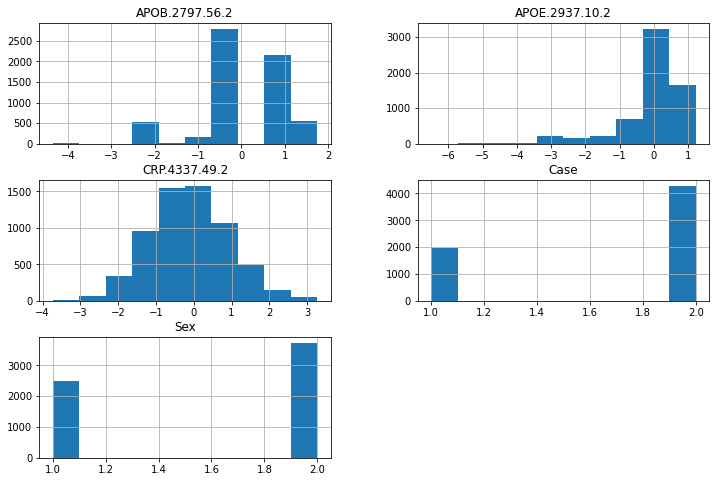

In [3]:
#Review missingness and distribution of variables

print(prs.describe())
print(prs.dtypes)

prs.hist(figsize=(12,8))

#Finding: consider whether need to further transform PRS (already normalised to Z scores - units of standard deviation)

In [4]:
#Check 3 groups and numbers in each categorical group

prs.groupby("Group").count()

,Case,Sex,APOB.2797.56.2,APOE.2937.10.2,CRP.4337.49.2
Group,,,,,
A,4492,4492,4492,4492,4492
B,1007,1007,1007,1007,1007
C,745,745,745,745,745


In [3]:
#Update case and sex from 2/1 and to dummy variables 1/0
#Case -> 1 = "AD", 0 = "CTL"
#Sex -> 1 = "Female", 0 = "Male"

if (prs["Case"].max() == 2) | (prs["Sex"].max() == 2):
    prs.loc[prs["Case"] == 1, "Case"] = 0
    prs.loc[prs["Case"] == 2, "Case"] = 1

    prs.loc[prs["Sex"] == 1, "Sex"] = 0
    prs.loc[prs["Sex"] == 2, "Sex"] = 1
else:
    print("Already updated")

print(prs[["Case", "Sex"]].describe())

print(prs.groupby("Group")["Case"].sum())

              Case          Sex
count  6244.000000  6244.000000
mean      0.686579     0.598334
std       0.463921     0.490274
min       0.000000     0.000000
25%       0.000000     0.000000
50%       1.000000     1.000000
75%       1.000000     1.000000
max       1.000000     1.000000
Group
A    3277
B     639
C     371
Name: Case, dtype: int64


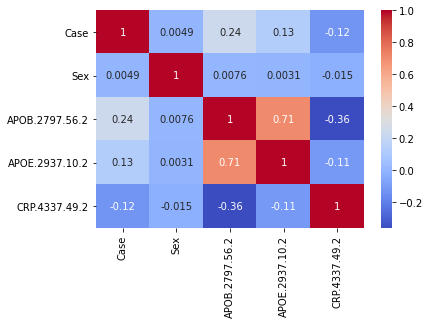

In [18]:
#Check correlation between PRS scores
sns.heatmap(prs.corr(), annot = True, cmap = "coolwarm")

#Finding: APOB and APOE are highly correlated (> 0.7). In full, multivariate models consider only selecting one.

In [35]:
#SKlearn modules and helper method to assess model performance

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

def assess_model_performance(md, pred, X_test, y_test, model_name, plot=True, univariate=True):
    accuracy_sk = md.score(X_test, y_test)
    auc = roc_auc_score(y_test, md.predict(X_test))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    sensitivity = tp / (tp + fn) #-> also recall
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    if not univariate:
        model_name = "+".join(list(model_name))
    
    result = pd.DataFrame({"model_name":model_name, 
                           "accuracy":accuracy_sk, 
                           "sensitivity": sensitivity, 
                           "specificity":specificity,
                           "precision":precision,
                           "auc":auc}, index=[1])
    
    if plot:
        probas = md.predict_proba(X_test)
        plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1], label=model_name)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend(prop={'size':10}, loc='lower right')
    
    return result

       model_name  accuracy  sensitivity  specificity  precision       auc
0  APOB.2797.56.2  0.684177     0.932710     0.142566   0.703312  0.537638
1  APOE.2937.10.2  0.687380     0.984112     0.040733   0.690945  0.512423
2   CRP.4337.49.2  0.684817     0.999065     0.000000   0.685256  0.499533


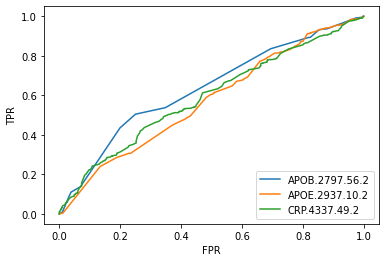

In [40]:
#Build univariate logistic regression models with each PRS single input using sklearn and calculate classification performance metrics

PROTEINS = list(prs.iloc[:, 3:].columns)
RESULTS = pd.DataFrame()

for protein in PROTEINS:
    x_train, x_test, y_train, y_test = train_test_split(prs[protein], prs["Case"], test_size=0.25, random_state=0)

    logr = LogisticRegression()

    X_train = np.array(x_train).reshape(-1,1)
    X_test = np.array(x_test).reshape(-1,1)

    md = logr.fit(X_train, y_train)

    pred = md.predict(X_test)

    result = assess_model_performance(md, pred, X_test, y_test, protein)
    RESULTS = RESULTS.append(result, ignore_index = True)

RESULTS.sort_values(by="auc", ascending=False, inplace=True)
print(RESULTS)
#NOTE - interesting that logr seems to apply method inplace, so could use md and logr interchangeably unless wanted to create copies

#Finding - Individual proteins not robust classifiers as AUC similar to chance. 
    #Classification weakness appears to be driven by inability to identify true negatives - effectively classifying everything as AD (training data does have high proportion of cases, much higher than a typical population)
    

In [30]:
#Build univariate logistic regression model using statsmodel (to assess R^2 and p-values)
import statsmodels.api as sm

for protein in PROTEINS:
        x_train, x_test, y_train, y_test = train_test_split(prs[protein], prs["Case"], test_size=0.25, random_state=0)
        #manually add intercept
        x_train = sm.add_constant(x_train)
        
        sm_md = sm.Logit(y_train, x_train).fit()
        
        print(sm_md.summary())
        
        x_test = sm.add_constant(x_test)
        
        sm_pred = sm_md.predict(x_test)
        
        auc = roc_auc_score(y_test, sm_pred)
        print(protein,"AUC", auc)
        
        


In [39]:
#Build multivariate logistic regression models for all possible combinations of PRS

#get all combinations of proteins
from itertools import combinations

RESULTS = pd.DataFrame()

for num in range(2, len(PROTEINS)+1):
    comb = combinations(PROTEINS, num)
    for i in list(comb):
        x_train, x_test, y_train, y_test = train_test_split(prs[(list(i))], prs["Case"], test_size=0.25, random_state=0)

        logr = LogisticRegression()

        X = np.array(x_train).reshape(-num,num)
        X_test = np.array(x_test).reshape(-num,num)

        md = logr.fit(X, y_train)

        pred = md.predict(X_test)

        result = assess_model_performance(md, pred, X_test, y_test, i, plot=False, univariate=False)
        RESULTS = RESULTS.append(result, ignore_index = True)

RESULTS.sort_values(by="auc", ascending=False, inplace=True)
print(RESULTS)

                                    model_name  accuracy  sensitivity  \
1                 APOB.2797.56.2+CRP.4337.49.2  0.684177     0.932710   
0                APOB.2797.56.2+APOE.2937.10.2  0.684177     0.933645   
3  APOB.2797.56.2+APOE.2937.10.2+CRP.4337.49.2  0.682896     0.934579   
2                 APOE.2937.10.2+CRP.4337.49.2  0.689302     0.983178   

   specificity  precision       auc  
1     0.142566   0.703312  0.537638  
0     0.140530   0.703026  0.537087  
3     0.134420   0.701754  0.534499  
2     0.048880   0.692561  0.516029  


In [24]:
#MOVE TO TEST 2

#Quick test setting up Grid Search with penalised regression (L2)
#Tests combinations of weightings in examples, not combinations of input variables
from sklearn.model_selection import GridSearchCV

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(-10, 10, 21)

# Create hyperparameter options
hyperparameters = dict(C=C)
print(hyperparameters)

#only worked with L2 specified
clf = GridSearchCV(estimator=LogisticRegression(penalty="l2"), param_grid=hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X, y_train)

print('Best C:', best_model.best_estimator_.get_params()['C'])

{'C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])}
Best C: 1.0


In [30]:
best_model.best_estimator_.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

All PRS L2 Accuracy 0.6828955797565663
All PRS L2 Sensitivity 0.9345794392523364
All PRS L2 Specificity 0.13441955193482688
All PRS L2 Precision 0.7017543859649122
All PRS AUC 0.5344994955935817


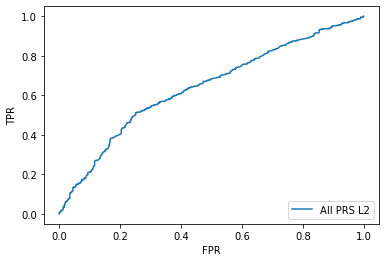

In [26]:
#MOVE TO TEST 2

pred_l2 = best_model.predict(X_test)

accuracy_mn = sum(pred_l2 == y_test) / y_test.count()
auc = roc_auc_score(y_test, pred_l2)

print("All PRS L2", "Accuracy", accuracy_mn)
tn, fp, fn, tp = confusion_matrix(y_test, pred_l2).ravel()
sensitivity = tp / (tp + fn) #-> also recall
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
print("All PRS L2", "Sensitivity", sensitivity)
print("All PRS L2", "Specificity", specificity)
print("All PRS L2", "Precision", precision)

probas_l2 = best_model.predict_proba(X_test)
plt.plot(roc_curve(y_test, probas_l2[:,1])[0], roc_curve(y_test, probas_l2[:,1])[1], label="All PRS L2")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(prop={'size':10}, loc='lower right')
print("All PRS", "AUC", auc)